In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Dropout, Flatten, AveragePooling2D, ReLU, UpSampling2D
from tensorflow.keras import backend
from tensorflow.keras.constraints import Constraint

## Load Data

In [2]:
(x_train, y_train), (_, _) = mnist.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)


x_train shape: (60000, 28, 28)
y_train shape: (60000,)


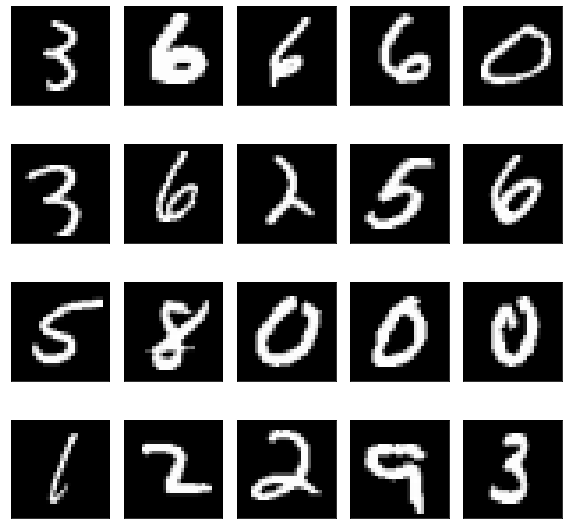

In [3]:
### Let's examine some sample images.
np.random.seed(seed = 0)
sample_images = x_train[np.random.choice(len(x_train), size=20, replace=False)]

plt.figure(figsize=(8, 8))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(sample_images[i], cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()


## Data Reshape

In this part, I first normalize each image array, to $[-1, 1]$, since the activation function we use in Generator is tanh. Then I reshape each image, since I plan to use the simple network for both Generator and Discriminator, and since the images are all have only one color channel (28, 28), I reshape each image to $(28\times28, )$.

In [4]:
### preprocess
def preprocess(x):
  x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])
  x = (x.astype(np.float32) - 127.5) /  127.5 ## normalize the image to -1 and 1

  return x

x_train = preprocess(x_train)

print('x_train shape:', x_train.shape)

x_train shape: (60000, 784)


## Wasserstein Loss

This is a self defined loss function, I will explain it in detail in the following train() function.

In [5]:
def wasserstein_loss(y_true, y_pred):
	return tf.reduce_mean(y_true * y_pred)

## Generator

Architecture: Input(100, ) -> Dense(128) -> LeakyReLU(0.01) -> Dense(784) -> Tanh

In [6]:
generator = tf.keras.Sequential([
                                 
                             Dense(128, input_shape = (100, )),
                             LeakyReLU(alpha = 0.01),
                             Dense(784, activation = 'tanh')
                            
                             #Dense(7*7*512, input_shape = (100, )),
                             #BatchNormalization(),
                             #ReLU(),

                             #Reshape((7, 7, 512)),

                             #Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = 'same', use_bias = False),
                             #BatchNormalization(),
                             #ReLU(),

                             #Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False),
                             #BatchNormalization(),
                             #ReLU(),

                             #Conv2DTranspose(filters = 1, kernel_size = (4, 4), strides = (1, 1), padding = 'same', use_bias = False, activation = 'tanh'),
                             #Conv2D(filters = 1, kernel_size = (7, 7), padding = 'same', activation = 'tanh')                           
])
#generator.compile(optimizer=tf.keras.optimizers.RMSprop(0.00005), loss = wasserstein_loss)

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


## Discriminator

Input(784, ) -> Dense(128) -> LeakyReLU(0.01) -> Dense(1) -> Linear

In [8]:
discriminator = tf.keras.Sequential([
                                     Dense(128, input_shape = (784, )),
                                     LeakyReLU(alpha = 0.01),
                                     Dense(1, activation='linear')
                                     #Conv2D(filters = 512, kernel_size = (3, 3), strides = (2, 2), padding = 'same', input_shape = (28, 28, 1), use_bias = True, kernel_constraint=const),
                                     #BatchNormalization(),
                                     #LeakyReLU(alpha = 0.2),
                                     #Dropout(0.3),

                                     #Conv2D(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = 'same', use_bias = True, kernel_constraint = const),
                                     #BatchNormalization(),
                                     #LeakyReLU(alpha = 0.2),
                                     #Dropout(0.3),
                                     #Conv2D(filters = 128, kernel_size = (3, 3), strides = (2, 2), padding = 'same', use_bias = True, kernel_constraint=const),
                                     #BatchNormalization(),
                                     #LeakyReLU(alpha = 0.2),
                                     #AveragePooling2D(pool_size = (4, 4)),

                                     #Flatten(),
                                     #Dense(1, activation = 'linear')                                     
])
discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.00005), loss = wasserstein_loss)

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


## Combine 2 Networks

In [10]:
def w_gan(generator, discriminator):
  discriminator.trainable = False
  model = tf.keras.Sequential()
  model.add(generator)
  model.add(discriminator)

  return model

wgan = w_gan(generator, discriminator)
wgan.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00005), loss = wasserstein_loss)

## Train

The formula of loss function:
$$Discriminator Loss = E_{z \sim p_{z}(z)}(D(G(z))) - E_{x\sim p_{data}(x)}(D(x))$$
$$Generator Loss = -E_{z\sim p_{z}(z)}(D(G(z)))$$

In the train() functin, I train the networks with MNIST dataset. To be specific:

+ in the discriminator loss, the coefficient of true images are **-1**, so when I set the true label of each true images, I set it as $y_{true} = -1$; the coefficient of fake images are **1**, so when I set the fake label of each fake images, I set it as $y_{fake} = 1$.

+ now we come to the Wasserstein Loss I defined above: mean$y_{pred} * y_{true}$. When I multiply the true labels (all $-1$) with the output of discriminator(true images), we can get the second item of discriminator loss $discriminator_{true images} * y_{true}$; 

+ Similarly, when I multiply the fake labels with the output of discriminator(fake images), we can get the first item of discriminator loss $discriminator_{fake images} * y_{fake}$; 

+ Similarly, when I multiply the output of WGAN model and the true labels, I can get the generator loss. $WGAN_{fake images} * y_{true}$

+ Also, I have included the part in the WGAN algorithm that limit the value of discriminator weights between **-0.01** and **0.01**

+ During the training process, I also show the D loss and G loss every 500 epochs and show the generated images evert 2000 epochs, to see the changes in loss and generated images.

In [11]:
def train(epochs, batch_size = 64, n_critic = 5):
  loss_dtrue = []
  loss_dfake = []
  loss_d = []
  loss_g = []

   
  y_train_real, y_train_fake = (-1)*np.ones((batch_size, 1)),  np.ones((batch_size, 1))
  #y_train_real = np.array(y_train_real, dtype = 'float32')
  #y_train_fake = np.array(y_train_fake, dtype = 'float32')
  #y_eval_real,  y_eval_fake  = make_labels(eval_size)

  for e in range(epochs):
    d1_l = []
    d2_l = []

    for i in range(n_critic):
      ### select 
      idx = np.random.randint(0, x_train.shape[0], batch_size)
      x_batch_real = x_train[idx] #true

      z = np.random.normal(loc = 0.0, scale = 1.0, size = (batch_size, 100)) #noise
      x_batch_fake = generator.predict(z)

      d1 = discriminator.train_on_batch(x_batch_real, y_train_real)
      d2 = discriminator.train_on_batch(x_batch_fake, y_train_fake)
      d1_l.append(d1)
      d2_l.append(d2)

      for l in discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -0.01, 0.01) for w in weights]
                    l.set_weights(weights)



    d = 0.5 * np.mean(np.array(d2_l) + np.array(d1_l))

    #loss_dtrue.append(np.mean(d1_l))
    #loss_dfake.append(np.mean(d2_l))
    loss_d.append(d)
    #make_trainable(discriminator, False)
    #z2 = np.random.normal(loc = 0.0, scale = 1.0, size = (batch_size, 100))
    g_loss = wgan.train_on_batch(z, y_train_real)
    loss_g.append(g_loss)

    ##print progress
    if e % 500 == 0:
      print ("%d [D loss: %f] [G loss: %f]" % (e, d, g_loss))
    if e % 2000 == 0:
      np.random.seed(seed = 0)
      generated_digits = wgan.layers[0].predict(np.random.normal(0, 1, (9, 100)))
      ### Let's examine some sample images.
      sample_images = generated_digits

      plt.figure(figsize=(5, 5))
      for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(sample_images[i].reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
      plt.tight_layout()
      plt.show()
        
  
  #loss_d = loss_d1 + loss_d2
  return loss_d, loss_g, wgan












0 [D loss: 0.090387] [G loss: 0.000596]


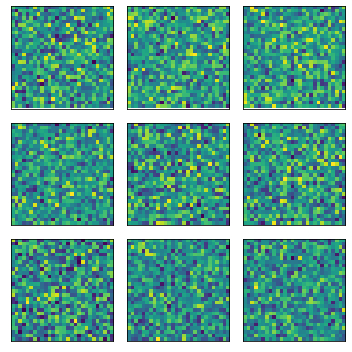

500 [D loss: -0.264239] [G loss: -2.736692]
1000 [D loss: 0.020696] [G loss: -2.686066]
1500 [D loss: 0.025777] [G loss: -2.026719]
2000 [D loss: 0.017423] [G loss: -1.412508]


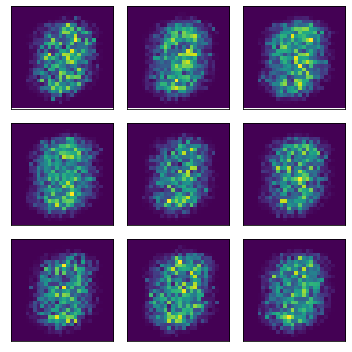

2500 [D loss: 0.012251] [G loss: -0.885673]
3000 [D loss: -0.018181] [G loss: -0.504861]
3500 [D loss: -0.035211] [G loss: -0.386890]
4000 [D loss: -0.051349] [G loss: -0.049106]


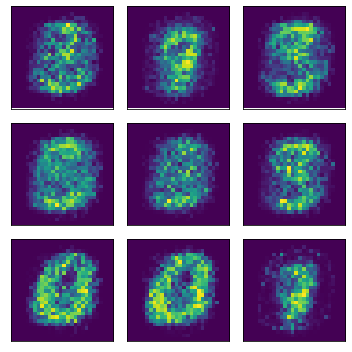

4500 [D loss: -0.072895] [G loss: -0.048554]
5000 [D loss: -0.055516] [G loss: -0.060816]
5500 [D loss: -0.053893] [G loss: -0.043105]
6000 [D loss: -0.040092] [G loss: -0.069191]


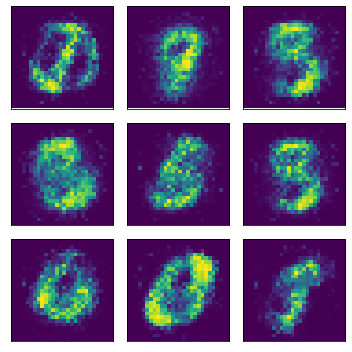

6500 [D loss: -0.040021] [G loss: -0.042686]
7000 [D loss: -0.036686] [G loss: -0.041328]
7500 [D loss: -0.030582] [G loss: -0.037648]
8000 [D loss: -0.029398] [G loss: -0.037225]


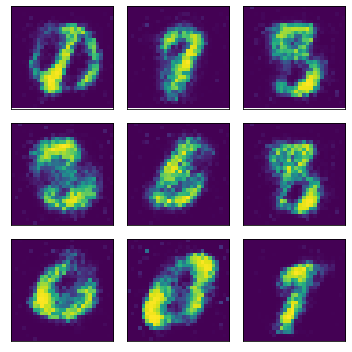

8500 [D loss: -0.024154] [G loss: -0.036759]
9000 [D loss: -0.025630] [G loss: -0.029136]
9500 [D loss: -0.025913] [G loss: -0.026307]
10000 [D loss: -0.018069] [G loss: -0.028535]


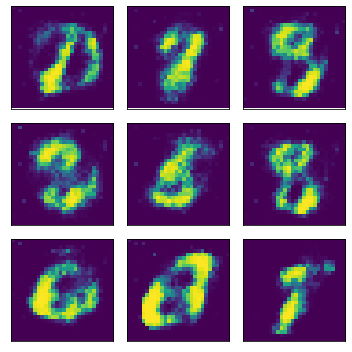

10500 [D loss: -0.018722] [G loss: -0.026016]
11000 [D loss: -0.018631] [G loss: -0.023853]
11500 [D loss: -0.016606] [G loss: -0.023687]
12000 [D loss: -0.015645] [G loss: -0.020861]


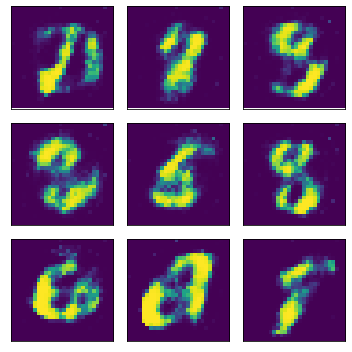

12500 [D loss: -0.015247] [G loss: -0.021685]
13000 [D loss: -0.014312] [G loss: -0.019753]
13500 [D loss: -0.012732] [G loss: -0.020535]
14000 [D loss: -0.011092] [G loss: -0.016984]


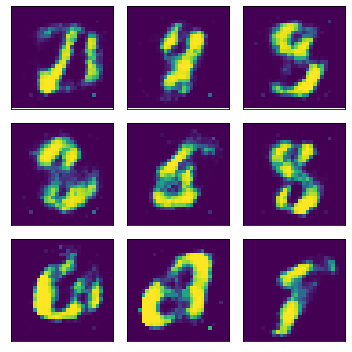

14500 [D loss: -0.011454] [G loss: -0.016784]
15000 [D loss: -0.011511] [G loss: -0.015056]
15500 [D loss: -0.011302] [G loss: -0.014420]
16000 [D loss: -0.009422] [G loss: -0.012803]


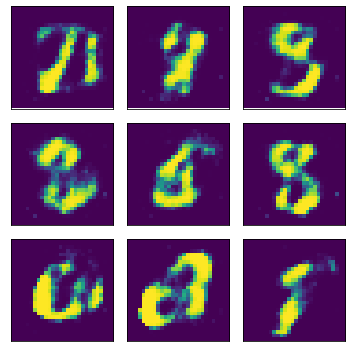

16500 [D loss: -0.009995] [G loss: -0.012544]
17000 [D loss: -0.009820] [G loss: -0.011872]
17500 [D loss: -0.010002] [G loss: -0.011404]
18000 [D loss: -0.008192] [G loss: -0.010556]


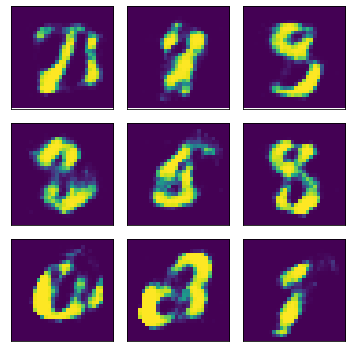

18500 [D loss: -0.008801] [G loss: -0.010349]
19000 [D loss: -0.008343] [G loss: -0.011062]
19500 [D loss: -0.008554] [G loss: -0.009084]
20000 [D loss: -0.007225] [G loss: -0.008581]


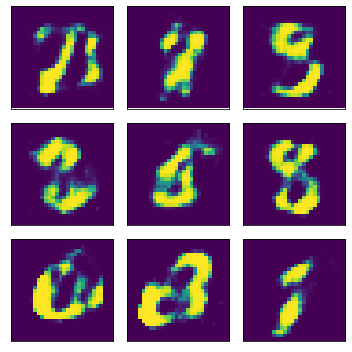

20500 [D loss: -0.008098] [G loss: -0.007488]
21000 [D loss: -0.007512] [G loss: -0.009000]
21500 [D loss: -0.007392] [G loss: -0.008707]
22000 [D loss: -0.006550] [G loss: -0.007076]


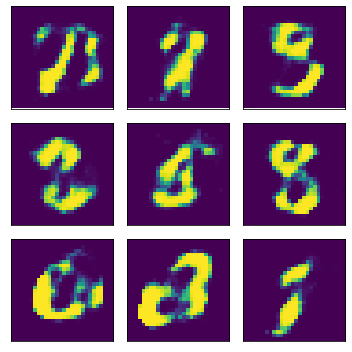

22500 [D loss: -0.007287] [G loss: -0.007684]
23000 [D loss: -0.006786] [G loss: -0.007946]
23500 [D loss: -0.006779] [G loss: -0.007871]
24000 [D loss: -0.006304] [G loss: -0.006290]


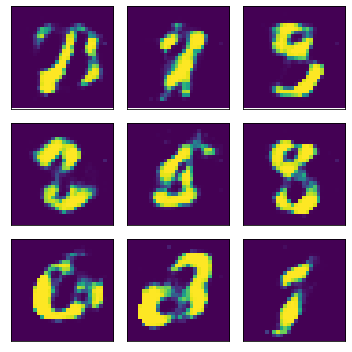

24500 [D loss: -0.006846] [G loss: -0.006571]
25000 [D loss: -0.006114] [G loss: -0.006652]
25500 [D loss: -0.006367] [G loss: -0.006541]
26000 [D loss: -0.006033] [G loss: -0.004798]


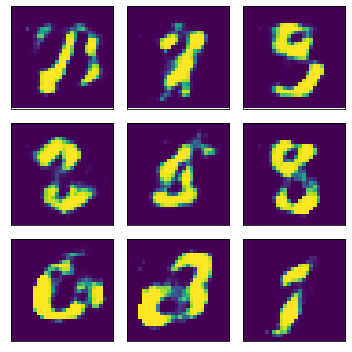

26500 [D loss: -0.006548] [G loss: -0.004722]
27000 [D loss: -0.005715] [G loss: -0.005965]
27500 [D loss: -0.005870] [G loss: -0.005767]
28000 [D loss: -0.005658] [G loss: -0.003786]


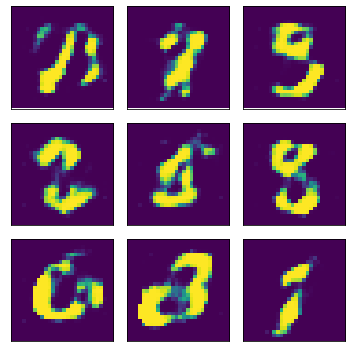

28500 [D loss: -0.006283] [G loss: -0.004185]
29000 [D loss: -0.005306] [G loss: -0.005197]
29500 [D loss: -0.005398] [G loss: -0.004972]
30000 [D loss: -0.005485] [G loss: -0.003208]


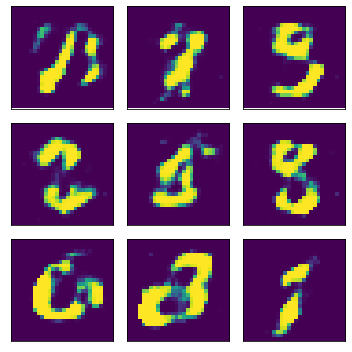

30500 [D loss: -0.006023] [G loss: -0.003293]
31000 [D loss: -0.005087] [G loss: -0.003934]
31500 [D loss: -0.005104] [G loss: -0.004487]
32000 [D loss: -0.005238] [G loss: -0.002615]


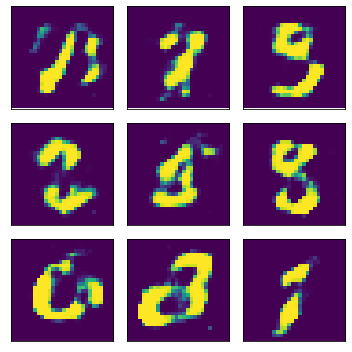

32500 [D loss: -0.005761] [G loss: -0.002809]
33000 [D loss: -0.004923] [G loss: -0.003040]
33500 [D loss: -0.005021] [G loss: -0.004182]
34000 [D loss: -0.005107] [G loss: -0.002298]


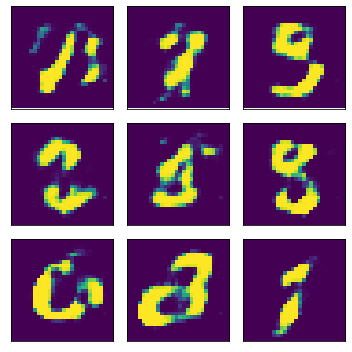

34500 [D loss: -0.005612] [G loss: -0.002983]
35000 [D loss: -0.004708] [G loss: -0.003030]
35500 [D loss: -0.004852] [G loss: -0.004192]
36000 [D loss: -0.004869] [G loss: -0.001946]


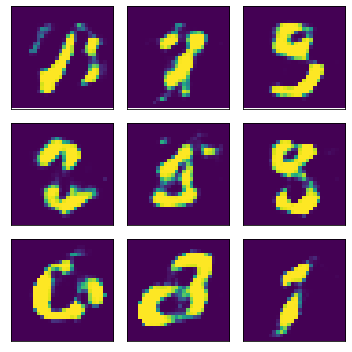

36500 [D loss: -0.005422] [G loss: -0.002186]
37000 [D loss: -0.004479] [G loss: -0.002379]
37500 [D loss: -0.004588] [G loss: -0.003696]
38000 [D loss: -0.004727] [G loss: -0.001565]


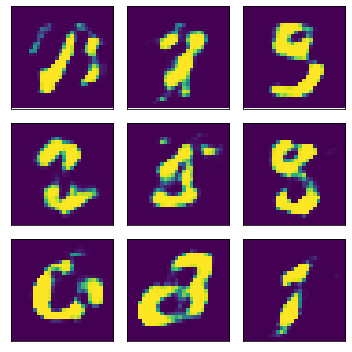

38500 [D loss: -0.005184] [G loss: -0.001689]
39000 [D loss: -0.004250] [G loss: -0.001895]
39500 [D loss: -0.004434] [G loss: -0.002523]
40000 [D loss: -0.004515] [G loss: -0.000940]


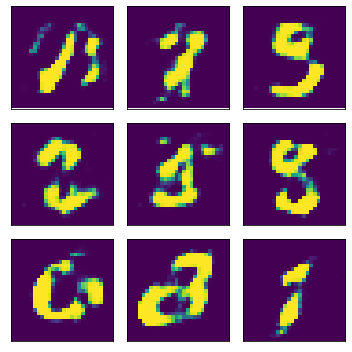

40500 [D loss: -0.004976] [G loss: -0.001378]
41000 [D loss: -0.004063] [G loss: -0.001686]
41500 [D loss: -0.004236] [G loss: -0.002265]
42000 [D loss: -0.004368] [G loss: -0.000515]


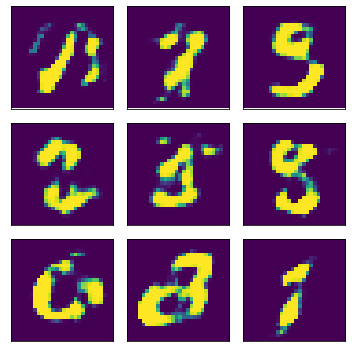

42500 [D loss: -0.004795] [G loss: -0.000937]
43000 [D loss: -0.003953] [G loss: -0.001536]
43500 [D loss: -0.004218] [G loss: -0.001741]
44000 [D loss: -0.004171] [G loss: -0.000338]


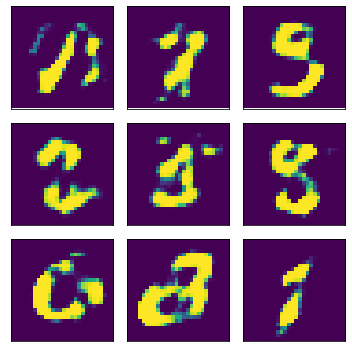

44500 [D loss: -0.004608] [G loss: -0.001175]
45000 [D loss: -0.003812] [G loss: -0.001211]
45500 [D loss: -0.004009] [G loss: -0.001619]
46000 [D loss: -0.003987] [G loss: -0.000151]


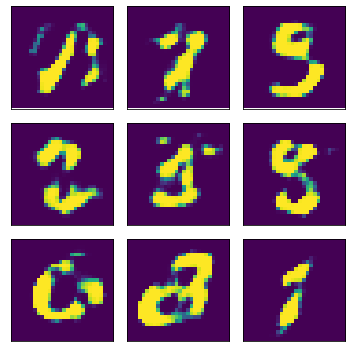

46500 [D loss: -0.004526] [G loss: -0.000913]
47000 [D loss: -0.003801] [G loss: -0.001294]
47500 [D loss: -0.003861] [G loss: -0.001758]
48000 [D loss: -0.003764] [G loss: -0.000376]


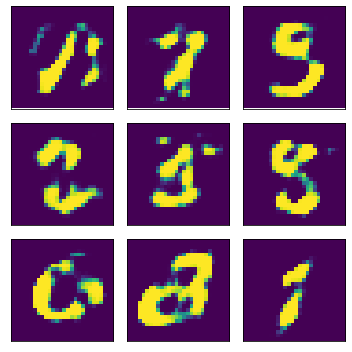

48500 [D loss: -0.004415] [G loss: -0.001061]
49000 [D loss: -0.003795] [G loss: -0.000907]
49500 [D loss: -0.003830] [G loss: -0.001748]


In [12]:
result = train(50000)

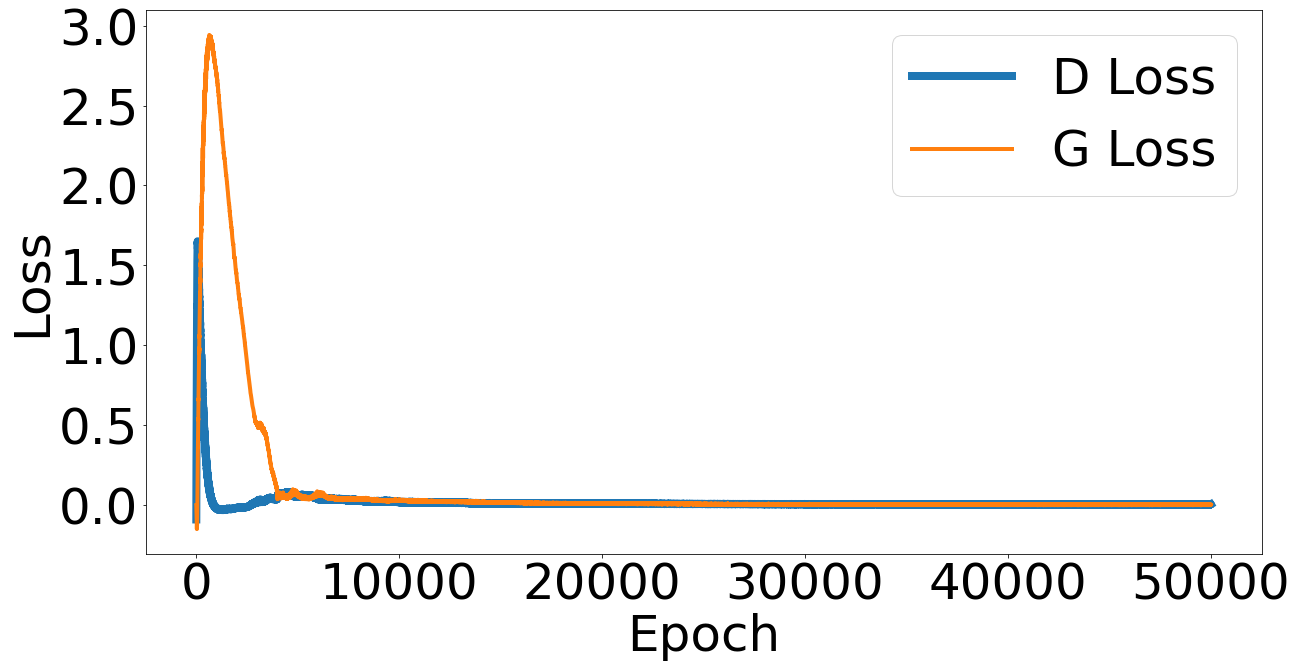

In [24]:
##plot the loss
plt.figure(figsize = (20, 10))
#plt.plot(range(1, 50001), (-1) * np.array(result[0]), label = 'D Loss')
#plt.plot(range(1, 50001), (-1) * np.array(result[1]), label = 'G Loss')
plt.plot(range(1, 50001), D, label = 'D Loss', linewidth = 8)
plt.plot(range(1, 50001), G, label = 'G Loss', linewidth = 4)

plt.xlabel('Epoch', fontsize = 50)
plt.ylabel('Loss', fontsize = 50)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)

plt.legend(fontsize = 50)


plt.show()


## Result

Here, I show the generated images after training 50000 epochs.

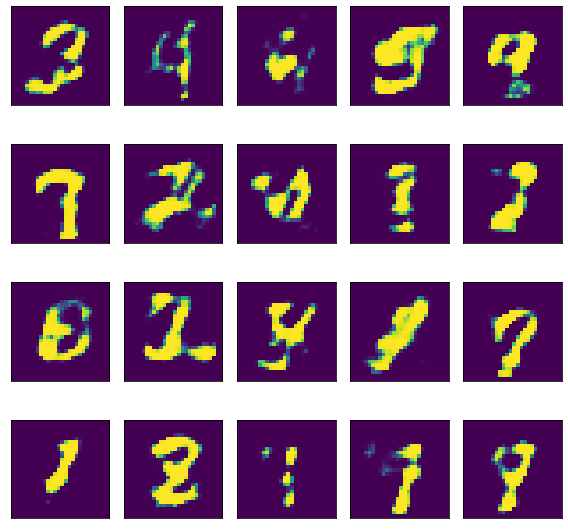

In [14]:
generated_digits = result[2].layers[0].predict(np.random.normal(0, 1, (20, 100)))

### Let's examine some sample images.
np.random.seed(seed = 0)
sample_images = generated_digits

plt.figure(figsize=(8, 8))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(sample_images[i].reshape(28, 28))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()
        


## Discussion

Based on the images I generated, I think more research needs to be done in the future, such as changing the architecture of networks, tuning the hyperparameter such as learning rate, etc.